## Data Preparation

In [20]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import json
import os
from bisect import bisect
from abc import *
from enum import Enum
import gurobipy as gp
from gurobipy import GRB
import random


In [21]:
sns.set()

### Utils

In [22]:
def powerset_by_length(items, min_len=1, max_len_exclusive=None, unpack_single=True):
    "Generate the subsets of elements in the iterable, in order by length."
    if max_len_exclusive is None:
        max_len_exclusive = len(items)+1
    for k in range(min_len, max_len_exclusive):
        for subset in itertools.combinations(items, k):
            yield subset[0] if k == 1 and unpack_single else subset

def values_key(tup_key):
    return tup_key[0] if len(tup_key) == 1 else tup_key

### Automatic Valuation Generation

In [23]:
class AuctionItem(ABC):
    @property
    @abstractmethod
    def identifier(self):
        pass

    @property
    @abstractmethod
    def cost(self) -> float:
        pass

    def __repr__(self):
        return f'{self.identifier}:{self.cost}'

    def __str__(self):
        return f'{self.identifier}'

@AuctionItem.register
class Land:
    def __init__(self, identifier: tuple[int, int], cost: int):
        self.identifier: tuple[int, int] = identifier
        self.cost: int = cost
        

class ValuationMode(Enum):
    sets = 'sets'
    neighbors = 'neighbors'

In [24]:
class ValuationFunction(ABC):

    @abstractmethod
    def generate_valuations(self, auction, mult):
        vals = {}
        for item in auction.items:
            val = np.random.randint(0, auction.value_max)
            while (val < auction.costs[item]):
                val = np.random.randint(0, auction.value_max)
            vals[item] = val
        return vals
    

@ValuationFunction.register
class AdditiveValuation():

    def generate_valuations(self, auction, mult):
        values = ValuationFunction.generate_valuations(self, auction, mult)
        if auction.valuation_mode == ValuationMode.sets:
            for subset in auction.itemgroups_to_value:
                if subset in values:
                    continue
                values[subset] = sum([values[s] for s in subset])
        else:
            for item in auction.itemgroups_to_value:
                values[item] = [values[item]] * (auction.max_num_neighbors+1)
        return values


@ValuationFunction.register
class SuperadditiveValuation():
        
    def generate_valuations(self, auction, mult):
        values = ValuationFunction.generate_valuations(self, auction, mult)
        if auction.valuation_mode == ValuationMode.sets:
            for subset in auction.itemgroups_to_value:
                if subset in values:
                    continue
                values[subset] = sum([values[s] for s in subset])
            for subset in auction.itemgroups_to_value:
                if (subset not in auction.items):
                    values[subset] = values[subset] * mult
        else:
            for item in auction.itemgroups_to_value:
                values[item] = [values[item]] * (auction.max_num_neighbors+1)
        return values


@ValuationFunction.register
class SubmodularNonmonotoneValuation(ValuationFunction):

    def generate_valuations(self, auction, mult):
        values = ValuationFunction.generate_valuations(self, auction, mult)
        if auction.valuation_mode == ValuationMode.sets:
            for subset in auction.itemgroups_to_value:
                if subset in values:
                    continue
                max_val = min([
                    values[values_key(subsubset)] + values[values_key(subsubset2)] \
                        - values.get(values_key(tuple(sorted(set(subsubset) & set(subsubset2)))), 0) # intersection of two sub-subsets
                    for subsubset in powerset_by_length(subset, len(subset)//2, len(subset), False)
                    for subsubset2 in powerset_by_length(subset, 1, len(subset), False)
                    if (set(subsubset) | set(subsubset2)) == set(subset)
                ])
                values[subset] = np.random.randint(max_val*0.9, max_val)
        return values


@ValuationFunction.register
class SubmodularMonotoneValuation(ValuationFunction):

    def generate_valuations(self, auction, mult):
        values = ValuationFunction.generate_valuations(self, auction, mult)
        if auction.valuation_mode == ValuationMode.sets:
            for subset in auction.itemgroups_to_value:
                if subset in values:
                    continue
                max_val = min([
                    values[values_key(subsubset)] + values[values_key(subsubset2)] \
                        - values.get(values_key(tuple(sorted(set(subsubset) & set(subsubset2)))), 0) 
                    for subsubset in powerset_by_length(subset, len(subset)//2, len(subset), False)
                    for subsubset2 in powerset_by_length(subset, 1, len(subset), False)
                    if (set(subsubset) | set(subsubset2)) == set(subset)
                ])
                min_val = max([values[values_key(subsubset)] for subsubset in powerset_by_length(subset, 1, len(subset), False)])
                values[subset] = max(min_val, max_val - np.random.randint(0, max(1, min(max_val*0.25, (max_val-min_val)*0.35)))) # this part I'm not sure of, the subtraction of this int
        return values

## Model Solving

In [25]:
class Auction:
    
    max_num_neighbors = 2
    # TODO vary
    costs_max = 50
    value_max = 100
    benefits_diff = 10
    max_diff = 5

    def __init__(self, valuation_function: ValuationFunction, items: list[AuctionItem], valuation_mode: ValuationMode, budg: int, mult: float):
        self.valuation_function: ValuationFunction = valuation_function
        self.item_objs: list[AuctionItem] = items
        self.items: list[str] = [item.identifier for item in items]
        self.costs = {item.identifier: item.cost for item in self.item_objs}
        self.valuation_mode: ValuationMode = valuation_mode
        self.itemgroups_to_value = self.items + list(powerset_by_length(self.items, 2)) \
            if valuation_mode == ValuationMode.sets \
            else self.items
        self.values: dict[Set[AuctionItem], float] = self.valuation_function.generate_valuations(self, mult)
        self.corridor_value: dict[Set[AuctionItem], float] = {}
        self.budget = budg
        self.multi = mult
        for item_set in self.itemgroups_to_value:
            corridor, check = 0, 0
            list_i, list_j = [], []
            for item_single in item_set:
                if (isinstance(item_single,int) == False):
                    list_i.append(item_single[0])
                    list_j.append(item_single[1])
            
            for i in list_i:
                if (list_i.count(i) == 3):
                    check += 1

            if (check == len(list_i)) and (check > 0):
                corridor = (check / 3)

            value_sum, count = 0, 0
            if (corridor == 1):
                self.values[item_set] = self.values[item_set] * mult
                self.corridor_value[item_set] = self.values[item_set]
            elif (corridor == 2):
                for subset in self.corridor_value:
                    flag = 1
                    for item_single in subset:
                        if item_single not in item_set:
                            flag = 0
                    if (flag != 0):
                        value_sum += self.values[subset]
                        count += 1
                self.values[item_set] = value_sum
                self.corridor_value[item_set] = self.values[item_set]
            
            min = 1e+05

            if (corridor > 2):
                for this_item in self.corridor_value:
                   if (len(this_item) > 3):
                        for that_item in self.corridor_value:
                            if (len(that_item) > 3):
                                if (set(this_item) | set(that_item) == set(item_set)):
                                    intersect = self.values.get(values_key(tuple(sorted(set(this_item) & set(that_item)))), 0) 
                                    if (self.values[this_item] + self.values[that_item] - intersect) < min:
                                        min = self.values[this_item] + self.values[that_item] - intersect
                self.values[item_set] = min 
                self.corridor_value[item_set] = self.values[item_set]


        for item_set in self.itemgroups_to_value:
            corridor_check, corridor_index = 0, 0
            corridor_index = []
            list_i = []
            if (item_set not in self.corridor_value):
                for item_single in item_set:
                    if (isinstance(item_single,int) == False):
                        list_i.append(item_single[0])
                for i in list_i:
                    if (list_i.count(i) == 3):
                        corridor_check += 1
                        corridor_index.append(i)           
                
                for indx in list(set(corridor_index)):
                    self.values[item_set] += (self.values[(indx, 1)] + self.values[(indx, 2)] +  self.values[(indx, 3)]) * (mult-1)
            
            


        # for i, j in zip(list_i, list_j):
            #     if (((i-1, j) in item_set) or ((i+1,j) in item_set) or ((i,j+1) in item_set) or ((i,j-1) in item_set)):
            #         count += 1
            # if ((count != len(item_set)) and (list_i != [])):
            #     item_groups.append(item_set)
        # self.values: dict[Set[AuctionItem], float] = self.valuation_function.generate_valuations(self)
        # for item_set in item_groups:
        #     del self.values[item_set]
        #     self.itemgroups_to_value.remove(item_set)
        # self.budget = np.random.randint(sorted_values[subsets_num//2], sorted_values[subsets_num*4//5])
        # self.budget = np.random.randint(max(self.costs.values()), sum(self.costs.values())) # Binding budget
        # self.budget = np.random.randint(max(sorted_values), 2*max(sorted_values))    # Non-binding budget




class Mechanism(ABC):
    
    @staticmethod
    def _add_indicators(model, x, auction):
        obj_exp = []
        for item in auction.itemgroups_to_value:
            dx = [0, 0, 1, -1]
            dy = [1, -1, 0, 0]
            neighbors = []
            l1, l2 = item
            for i,j in zip(dx, dy):
                if (l1+i, l2+j) in x:
                    neighbors.append(x[l1+i, l2+j])
            indicator_vars = []
            for n in range(len(neighbors)+1):
                indicator_vars.append(indicator_var := model.binary_var_dict([(item, n)], name='indicator:(cell_index)_num_neighbors')[item, n])
                obj_exp.append(x[item] * benefits[item][n] * indicator_var)
                model.add_indicator(indicator_var, model.sum(neighbors) == n, name=f'indicator {n} for var {item}')
            model.add_constraint(model.sum(indicator_vars) == 1, f'indicator single assign {item}')
        return obj_exp
    
    @staticmethod
    def _calculate_benefit(auction, x):
        if auction.valuation_mode == ValuationMode.sets:
            pos_vars = tuple([item for item, x_i in zip(auction.items, x) if x_i])
            return auction.values.get(pos_vars[0] if len(pos_vars) == 1 else pos_vars, 0)
        else:    
            score = 0
            for idx, item in enumerate(auction.items):
                if not x[idx]:
                    continue
                dx = [0, 0, 1, -1]
                dy = [1, -1, 0, 0]
                neighbors = 0
                l1, l2 = item
                for i,j in zip(dx, dy):
                    if (l1+i, l2+j) in x:
                        neighbors += 1
                score += auction.values[item][neighbors]
        return score

    @staticmethod
    def _calculate_cost(auction, x):
        return sum((auction.costs[auction.items[i]] for i, xi in enumerate(x) if xi))

    @abstractmethod
    def get_assignments_and_prices(self, trial_name, auction):
        model = gp.Model(trial_name)
        model.setParam('OutputFlag', False)
        x = {(i): model.addVar(vtype=GRB.BINARY, name="x%s"%str([i])) for i in auction.itemgroups_to_value}
        if auction.valuation_mode == ValuationMode.neighbors:
            obj_exp = Mechanism._add_indicators(model, x, auction)
        else:
            obj_exp = (auction.values[item] * x[item] for item in auction.itemgroups_to_value)
            model.addConstr(gp.quicksum(x[item] for item in auction.itemgroups_to_value) <= 1, name='constr1')
            y = {(i): model.addVar(vtype=GRB.BINARY, name="y%s"%str([i])) for i in auction.items}
            for item_set, x_item in x.items():
                if type(item_set[0]) != tuple:
                    item_set = (item_set,)
                # conditional constraint on value of x_item
                model.addConstr((x_item == 1) >> (gp.quicksum([y[item] for item in item_set]) == len(item_set)), name='constr2')
                model.addConstr((x_item == 0) >> (gp.quicksum([y[item] for item in item_set]) <= len(item_set)), name='constr3')
        cost_var = y if auction.valuation_mode == ValuationMode.sets else x
        costs_exp = model.addVar(vtype=GRB.INTEGER, name='c')
        model.addConstr((costs_exp == gp.quicksum((cost_var[k] * cost for k, cost in auction.costs.items()))), name='constr4')
        model.setObjective(gp.quicksum(obj_exp) - costs_exp, GRB.MAXIMIZE)

        return model, cost_var


@Mechanism.register
class VCGMechanism:
    
    @staticmethod
    def _optimal_with_constraint(model, constraint, constraint_name):
        temp_constr = model.addConstr(constraint, name=constraint_name)
        model.optimize()
        model.write('vcg.lp')
        if (model.objVal):
            net_benefits = model.objVal
        else:
            net_benefits = None
        model.remove(temp_constr)
        return net_benefits

    def get_assignments_and_prices(self, trial_name, auction):
        model, y = Mechanism.get_assignments_and_prices(self, trial_name, auction)
        total_payment = 0
        assign = []
        for item, item_var in y.items():
            conserve_net_benefits = VCGMechanism._optimal_with_constraint(model, item_var == 1, 'item = 1')
            develop_net_benefits = VCGMechanism._optimal_with_constraint(model, item_var == 0, 'item = 0')
            if conserve_net_benefits is None or develop_net_benefits is None:
                print('error iteration land', item)
                assign.append(0)
                continue
            conserve_net_benefits += auction.costs[item]
            payment = conserve_net_benefits - develop_net_benefits
            if payment >= auction.costs[item]:
                total_payment += payment
                print(f'landowner of {item} will be paid {round(payment, 2)} had bid/cost of {auction.costs[item]}')
                assign.append(1)
            else:
                assign.append(0)
        return Mechanism._calculate_benefit(auction, assign) - Mechanism._calculate_cost(auction, assign), total_payment


@Mechanism.register
class OptimalBudgetMechanism():
    
    def get_assignments_and_prices(self, trial_name, auction):
        model, y = Mechanism.get_assignments_and_prices(self, trial_name, auction)
        price = {(i): model.addVar(vtype=GRB.INTEGER, name="p%s"%str([i])) for i in y.keys()}
        model.addConstrs((price[yi] >= (y[yi] * auction.costs[yi]) for yi in y), name='constr5')
        model.addConstr((gp.quicksum(price.values()) <= auction.budget), name='budget')
        model.optimize()
        model.write('opt.lp')
        objective = model.objVal
        payments = 0
        for v in price.values():
            # print("{}: {}".format(v.varName, v.X))
            payments += v.X
        for v in model.getVars():
            if (v.X == 0):
                continue
            print("{}: {}".format(v.varName, v.X))

        return objective, payments

@Mechanism.register
class ClockBudgetMonotoneMechanism:

    def get_assignments_and_prices(self, trial_name, auction):
        if auction.valuation_mode != ValuationMode.sets:
            return None, None
        # need python version that maintains order of insertion in dicts
        active_bidders = dict.fromkeys(auction.items)
        prev_accept_bidders = dict()
        cur_accept_bidders = {auction.items[np.argmax([auction.values[item] for item in auction.items])]: True}
        print('cur_accept_bidders', cur_accept_bidders)
        cur_round = 1
        prices = {b: auction.budget for b in active_bidders}
        cur_optim_estimate = self._get_set_value(auction.values, cur_accept_bidders)
        while remain_bidders := list(self._dict_keys_difference(active_bidders, prev_accept_bidders | cur_accept_bidders)):
            # start a new phase
            cur_round += 1
            print('New phase', cur_round)
            cur_optim_estimate *= 2
            prev_accept_bidders = dict(cur_accept_bidders)
            cur_accept_bidders = dict()
            while self._get_set_value(auction.values, cur_accept_bidders) < cur_optim_estimate and \
            (remain_bidders := list(self._dict_keys_difference(active_bidders, prev_accept_bidders | cur_accept_bidders))):
                print(f'prev accepted bidders is {prev_accept_bidders}')
                print('cur_accept', list(cur_accept_bidders), 'remain_bidders', remain_bidders)
                max_marginal_contrib = remain_bidders[np.argmax([self._get_set_value(auction.values, cur_accept_bidders | {bidder: True}, marginal=True) for bidder in remain_bidders])]
                print('values', {bidder: self._get_set_value(auction.values, cur_accept_bidders | {bidder: True}, marginal=True) for bidder in remain_bidders})
                print('marg', max_marginal_contrib)
                print('prices', prices, 'new set', list(cur_accept_bidders | {max_marginal_contrib: True}))
                prices[max_marginal_contrib] = min(prices[max_marginal_contrib], round(self._get_set_value(auction.values, cur_accept_bidders | {max_marginal_contrib: True}, marginal=True) * auction.budget / cur_optim_estimate, 2))
                print('prices', prices)
                if auction.costs[max_marginal_contrib] <= prices[max_marginal_contrib]:  # accepts price
                    # add bidder i to current solution
                    cur_accept_bidders[max_marginal_contrib] = True
                else: 
                    # permanently eliminate bidder i
                    active_bidders.pop(max_marginal_contrib)
                print('active', list(active_bidders), 'cur_accept', list(cur_accept_bidders))

        w1 = dict(prev_accept_bidders)
        w2_ = dict(cur_accept_bidders)

        # enforce budget feasibility of W1
        if sum([prices[i] for i in w1]) > auction.budget:
            print('prev_accept_bidders', prev_accept_bidders)
            last_added_bidder = list(prev_accept_bidders)[-1]
            print('last_added_bidder', last_added_bidder)
            prices[last_added_bidder] = min(prices[last_added_bidder], round(self._get_set_value(auction.values, cur_accept_bidders |  {last_added_bidder: None}, marginal=True) * auction.budget / cur_optim_estimate, 2))
            print('prices', prices)
            w1.pop(last_added_bidder)
            if auction.costs[last_added_bidder] <= prices[last_added_bidder]:  # accepts price
               # move the last bidder j* to W2
                w2_[last_added_bidder] = True

        return self._max_value(w1, w2_, prices, auction)
    
    @staticmethod
    def _get_set_value(benefits, bid_set, marginal=False):
        bid_tup = tuple(sorted(bid_set))
        value = benefits.get(bid_tup[0] if len(bid_tup) == 1 else bid_tup, 0)
        if marginal and len(bid_set) > 1:
            value -= ClockBudgetMonotoneMechanism._get_set_value(benefits, list(bid_set)[:-1])
        return value

    @staticmethod
    def _dict_keys_difference(d1, d2):
        rem_keys = set(d1) - set(d2)
        return {k: v for k, v in d1.items() if k in rem_keys}

    @staticmethod
    def _max_value(w1, w2_, prices, auction):
        print('w1', w1)
        # can be replaced with other algos
        cum_prices_w2_ = np.cumsum([prices[i] for i in w2_])
        budget_idx = bisect(cum_prices_w2_, auction.budget)
        w2 = dict.fromkeys(list(w2_)[:budget_idx])  # longest budget-feasible prefix of w2_
        print(auction.budget, cum_prices_w2_, budget_idx, w2)
        if w2_:
            T = dict.fromkeys(list(w1)[:bisect(np.cumsum([prices[i] for i in w1]), auction.budget-cum_prices_w2_[budget_idx-1])])  # longest prefix of W1 such that W2 ∪ T is budget-feasible
            w3 = w2 | T
            print(auction.budget-cum_prices_w2_[budget_idx-1], np.cumsum([prices[i] for i in w1]), bisect(np.cumsum([prices[i] for i in w1]), auction.budget-cum_prices_w2_[budget_idx-1]))
            print('w3', w3, 'T', T)
        else:
            w3 = {}
        get_value_fn = ClockBudgetMonotoneMechanism._get_set_value
        print('w1', w1, get_value_fn(auction.values, w1), 'w3', w3, get_value_fn(auction.values, w3))
        w = w3 if get_value_fn(auction.values, w1) < get_value_fn(auction.values, w3) else w1
                # - sum([auction.costs[i] for i in w1])           - sum([auction.costs[i] for i in w3])
        print('clock final set', list(w))
        return get_value_fn(auction.values, w) - sum([auction.costs[i] for i in w]), sum([prices[i] for i in w])

@Mechanism.register
class ClockBudgetNonMonotoneMechanism:

    def get_assignments_and_prices(self, trial_name, auction):
        pass


## Experiments

In [26]:
testsets_per_val_type = 10
val_types = [
    # ('additive', AdditiveValuation), 
     ('superadditive', SuperadditiveValuation), 
    # ('submodular_monotone', SubmodularMonotoneValuation),
    # ('submodular_nonmonotone', SubmodularNonmonotoneValuation)
]

In [27]:
valuation_mode = ValuationMode.sets
save_results = False

sampl = random.sample(range(70, 80), 10)
# sampl = [ 85, 90,146, 69,105, 66,115,144, 63, 92,106,128,146,128,129,124,114,109,
  # 87, 97,115, 87, 75, 73, 64, 78,124, 78,103, 98,109, 55, 75, 56,117,131,
  # 88, 55, 69, 61, 53, 66, 79, 72, 85,131,109, 62, 54, 54]
# sampl = np.random.randint(low=50, high=150, size=(100,))
# print(np.array2string(sampl, separator=","))



In [28]:
np.random.seed(11)
datasets = []

results = pd.DataFrame(columns=['binding','budget', 'clock_mono_obj','clock_mono_payment', 'size','valuation_fn', 'multiplier', 'clock_mono_runtime'])
# results = pd.DataFrame(columns=['binding','budget', 'budget_obj', 'vcg_obj', 'clock_mono_obj', 'budget_payment', 'vcg_payment',  'clock_mono_payment', 'size','valuation_fn', 'multiplier', 'budget_runtime', 'vcg_runtime', 'clock_mono_runtime'])
# results2 = pd.DataFrame(columns=['binding','budget', 'budget_obj', 'vcg_obj', 'clock_mono_obj', 'budget_payment', 'vcg_payment',  'clock_mono_payment', 'size','valuation_fn', 'multiplier', 'budget_runtime', 'vcg_runtime', 'clock_mono_runtime'])

# TODO vary
rows, cols = 3,3

vals = [1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 2.0]
multiplier = vals[6]

if save_results:
    os.mkdir(path:=f'./bio/data/{str(datetime.now())}')
for vtype, vtype_fn in val_types:
    valuation_function = vtype_fn()
    for ti in range(testsets_per_val_type):
        auction_items = [
            Land(
                identifier=(r+1, c+1), 
                cost=np.random.randint(0, Auction.costs_max)
            )
            for r in range(rows) for c in range(cols)
        ]
    
            
        auction = Auction(valuation_function, auction_items, valuation_mode, sampl[ti], multiplier)
        print(f'Testset {ti} for val {vtype} of rows={rows} cols={cols}')
        print(f'budget {auction.budget} - multiplier {auction.multi}')

        print(f'tuple 1 - {auction.values[(1, 1), (1, 2), (1, 3)]}')
        print(f'tuple 2 - {auction.values[(2, 1), (2, 2), (2, 3)]}')
        print(f'tuple 3 - {auction.values[(3, 1), (3, 2), (3, 3)]}')
        print(f'tuple 12 - {auction.values[(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]}')
        print(f'tuple 13 - {auction.values[(1, 1), (1, 2), (1, 3), (3, 1), (3, 2), (3, 3)]}')
        print(f'tuple 23 - {auction.values[(2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]}')
        print(f'tuple 123 - {auction.values[(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]}')
        
        if auction.valuation_mode == 'neighbors':
            print('maps land cell c -> list l of 5 elements for i = 0..4 where l_i = benefit of conserving c when it has i direct neightbors')
        # print('benefits', auction.values)
        # print('costs', auction.costs)
        if save_results:
            with open(f'{path}/{ti}_{vtype}_{rows,cols}_benefits.json', 'w') as f:
                json.dump({str(k): {i: int(n) for i, n in enumerate(v)} if auction.valuation_mode == ValuationMode.neighbors else int(v) for k, v in auction.values.items()}, f)
            with open(f'{path}/{ti}_{vtype}_{rows,cols}_costs.json', 'w') as f:
                json.dump({str(k): int(v) for k, v in auction.costs.items()}, f)
        datasets.append(auction)
        print('------------------')
        # print('VCG')
        time_before = datetime.now()
        vcg_obj_val, vcg_payment = VCGMechanism().get_assignments_and_prices('VCG', auction)
        print('runtime:', vcg_runtime:= (datetime.now()-time_before).total_seconds(), 's')
        print(f'total payment {vcg_payment} total welfare {vcg_obj_val}')
        print('-----')
        print('budget')
        time_before = datetime.now()
        budg_obj_val, budg_payment = OptimalBudgetMechanism().get_assignments_and_prices('optimal budget', auction)
        print('runtime:', budg_runtime:= (datetime.now()-time_before).total_seconds(), 's')
        print(f'total payment {budg_payment} total welfare {budg_obj_val}')
        # print('-----')
        clock_mono_obj_val, clock_mono_payment, clock_mono_runtime = 0, 0, 0
        clock_obj_val, clock_payment, clock_runtime = 0, 0, 0
        # if vtype == 'submodular_monotone':
        print('clock monotone')
        time_before = datetime.now()
        clock_mono_obj_val, clock_mono_payment = ClockBudgetMonotoneMechanism().get_assignments_and_prices('clock monotone', auction)
        print('runtime:', clock_mono_runtime:= (datetime.now()-time_before).total_seconds(), 's')
        print(f'total payment {clock_mono_payment} total welfare {clock_mono_obj_val}')
        print('------------------')
        results.loc[len(results)] = ['yes', auction.budget, clock_mono_obj_val, clock_mono_payment,(rows, cols), vtype, multiplier, clock_mono_runtime]

        # results.loc[len(results)] = ['yes', auction.budget, budg_obj_val, vcg_obj_val, clock_mono_obj_val, budg_payment, vcg_payment, clock_mono_payment,(rows, cols), vtype, multiplier, budg_runtime, vcg_runtime, clock_mono_runtime]

        # ## NON - BINDING BUDGET
        # print(' ********** HERE NON_ BINDING BUDGETS')
        # sorted_values = sorted(auction.values.values())
        # auction.budget = np.random.randint(max(sorted_values), 2*max(sorted_values))
        # print(auction.budget)
        # print('------------------')
        # print('VCG')
        # time_before = datetime.now()
        # vcg_obj_val, vcg_payment = VCGMechanism().get_assignments_and_prices('VCG', auction)
        # print('runtime:', vcg_runtime:= (datetime.now()-time_before).total_seconds(), 's')
        # print(f'total payment {vcg_payment} total welfare {vcg_obj_val}')
        # print('-----')
        # print('budget')
        # time_before = datetime.now()
        # budg_obj_val, budg_payment = OptimalBudgetMechanism().get_assignments_and_prices('optimal budget', auction)
        # print('runtime:', budg_runtime:= (datetime.now()-time_before).total_seconds(), 's')
        # print(f'total payment {budg_payment} total welfare {budg_obj_val}')
        # print('-----')
        # clock_mono_obj_val, clock_mono_payment, clock_mono_runtime = 0, 0, 0
        # clock_obj_val, clock_payment, clock_runtime = 0, 0, 0
        # print('clock monotone')
        # time_before = datetime.now()
        # clock_mono_obj_val, clock_mono_payment = ClockBudgetMonotoneMechanism().get_assignments_and_prices('clock monotone', auction)
        # print('runtime:', clock_mono_runtime:= (datetime.now()-time_before).total_seconds(), 's')
        # print(f'total payment {clock_mono_payment} total welfare {clock_mono_obj_val}')
        # print('------------------')
        # results2.loc[len(results2)] = ['no', auction.budget, budg_obj_val, vcg_obj_val, clock_mono_obj_val, budg_payment, vcg_payment, clock_mono_payment,(rows, cols), vtype, multiplier, budg_runtime, vcg_runtime, clock_mono_runtime]
    
results = results.sort_values(by=['budget'])
results = results.reset_index(drop=True)

bind_file = 'bfa_results_superadd-'+str(multiplier)+'.csv'
results.to_csv(bind_file)  

mean_budget_obj = results['clock_mono_obj'].mean()
mean_budget_pay = results['clock_mono_payment'].mean()

print(f'Original objective {mean_budget_obj} and payments {mean_budget_pay}')
# results2 = results2.sort_values(by=['budget'])
# results2 = results2.reset_index(drop=True)

# nonbind_file = 'non'+bind_file
#results2.to_csv(nonbind_file)  





Testset 0 for val superadditive of rows=3 cols=3
budget 73 - multiplier 2.0
tuple 1 - 688.0
tuple 2 - 364.0
tuple 3 - 780.0
tuple 12 - 1052.0
tuple 13 - 1468.0
tuple 23 - 1144.0
tuple 123 - 1832.0
------------------
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-10


landowner of (1, 1) will be paid 645.0 had bid/cost of 25
landowner of (1, 2) will be paid 636.0 had bid/cost of 16
landowner of (1, 3) will be paid 647.0 had bid/cost of 27
landowner of (2, 1) will be paid 339.0 had bid/cost of 17
landowner of (2, 2) will be paid 335.0 had bid/cost of 13
landowner of (2, 3) will be paid 334.0 had bid/cost of 12
landowner of (3, 1) will be paid 755.0 had bid/cost of 33
landowner of (3, 2) will be paid 727.0 had bid/cost of 7
landowner of (3, 3) will be paid 740.0 had bid/cost of 18
runtime: 1.65719 s
total payment 5158.0 total welfare 1664.0
-----
budget
x[((3, 1), (3, 2), (3, 3))]: 1.0
y[(3, 1)]: 1.0
y[(3, 2)]: 1.0
y[(3, 3)]: 1.0
c: 58.0
p[(3, 1)]: 33.0
p[(3, 2)]: 7.0
p[(3, 3)]: 18.0
runtime: 0.179963 s
total payment 58.0 total welfare 722.0
clock monotone
cur_accept_bidders {(1, 1): True}
New phase 2
prev accepted bidders is {(1, 1): True}
cur_accept [] remain_bidders [(1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]
values {(1, 2): 48

In [29]:
import pandas as pd
data = pd.read_csv("draft.csv", delimiter= ',')
data

ax = data[['1.1', '1.2', '1.3', '1.4', '1.5', '1.7', '2']].plot(kind='box', title='BFA / OPT Relative Efficiency - Submodular Corridors')
plt.xlabel('superadditivity multiplier')
plt.ylabel('ratio')
# plt.ylim(0,0.025)


# Display the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'draft.csv'

### Analysis

In [ ]:
def plot_hist_diff(diff_col1, diff_col2, hue_col='valuation_fn'):
    sns.histplot(results, x=results[diff_col1]-results[diff_col2], hue=hue_col, multiple="dodge")
    plt.xlabel(f'{diff_col1} - {diff_col2}')
    plt.ylabel('count');
    plt.title(f'Difference between {diff_col1} and {diff_col2} Histogram');

#### VCG Budget feasibility

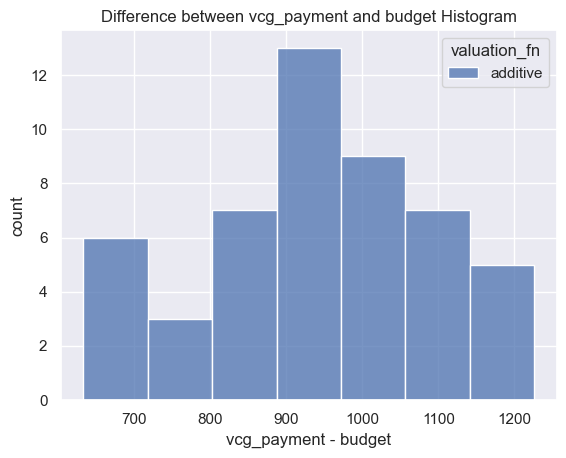

In [ ]:
plot_hist_diff('vcg_payment', 'budget')

#### Budget vs VCG Obj Value difference

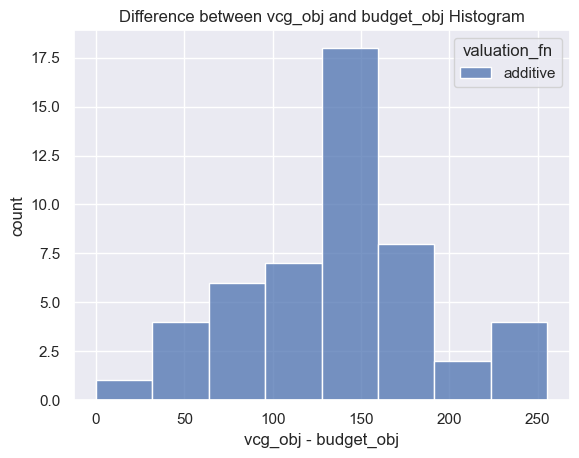

In [ ]:
plot_hist_diff('vcg_obj', 'budget_obj')

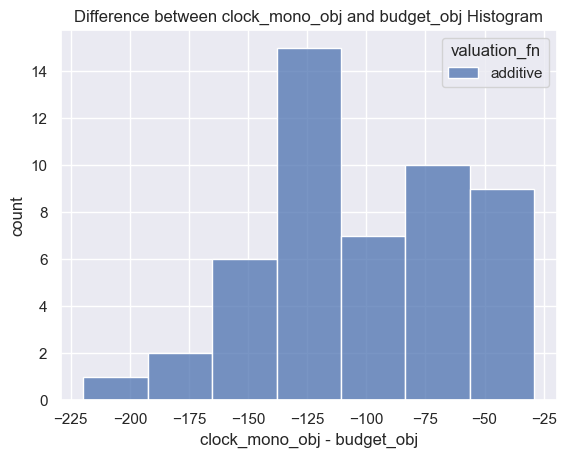

In [ ]:
plot_hist_diff('clock_mono_obj', 'budget_obj')

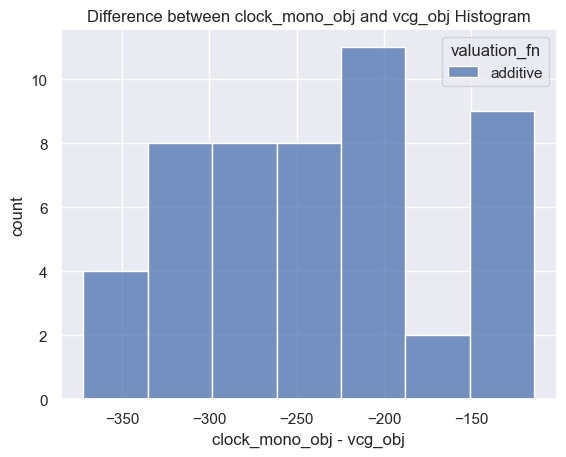

In [ ]:
plot_hist_diff('clock_mono_obj', 'vcg_obj')

#### VCG vs Budget Runtime in seconds

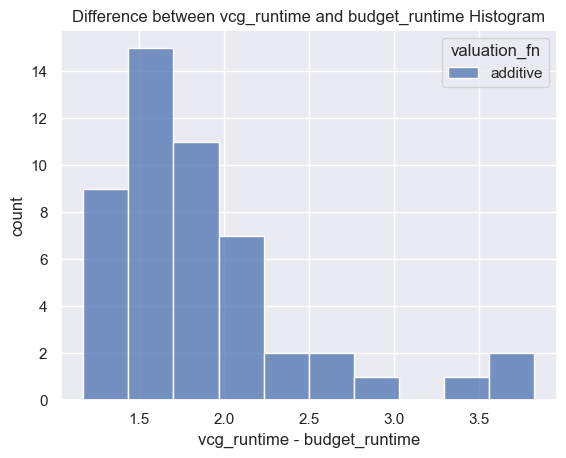

In [ ]:
plot_hist_diff('vcg_runtime', 'budget_runtime')

## Conclusions

- <conclusion>

## References

- Walker M (1980) On the nonexistence of a dominant strategy mechanism for making optimal public decisions. Econometrica 48(6):1521–1540
- Polasky, S., D. Lewis, A. Plantinga, and E. Nelson. 2014. Implementing the Optimal Provision of Ecosystem Services. Proceedings of the National Academy of Sciences 111 (17): 6248–53.
- Li, W. D., Ashlagi, I., & Lo, I. (2022). Simple and approximately optimal contracts for payment for ecosystem services. Management Science.
- Balkanski, E., Garimidi, P., Gkatzelis, V., Schoepflin, D., & Tan, X. (2022). Deterministic Budget-Feasible Clock Auctions∗. In Proceedings of the 2022 Annual ACM-SIAM Symposium on Discrete Algorithms (SODA) (pp. 2940-2963). Society for Industrial and Applied Mathematics.

PES paper cost function

$c(x) = \frac{h}{2} x^2$, where $h > 0$, and for $x < 0$, $c(x) = 0.$

$h$ calibrated in EC1 page 30,31 in pdf

deterministic
clock
submodular
budget-feasible
backward-greedy algos